In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random as npr

import keras as kr
from keras.models import Sequential
from keras.layers import Dense, Dropout
import keras.optimizers as opt

from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle

import pandas as pd

from sklearn.ensemble import GradientBoostingClassifier
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance, to_graphviz, plot_tree
print("XGBoost version:",xgboost.__version__)

np.random.seed(69420)

## Creating a dataset
We created a dataset which features a sine wave, a square and a circle to classify

In [2]:
def classify(a,b):
    r=0
    if (b > np.sin(2*a)+a) or (a > 8 and b < 2):
        r=1
    if ((a-2)**2 + (b-8)**2 < 1):
        r=0
    return int(r)

In [3]:
N=3000
X = 10*npr.rand(N,2)
y = np.zeros(N)
for i in range(N):
    y[i]=classify(X[i,0],X[i,1])

In [ ]:
fig, AX = plt.subplots()

AX.scatter(X[:, 0], X[:, 1], c=y)
AX.set_title('Data')

In [ ]:
permutation = np.random.permutation(X.shape[0])

train_percentage=0.8
tsize = int(train_percentage*N)

X = X[permutation]
y = y[permutation]

X_train, X_valid = X[:tsize], X[tsize:]
y_train, y_valid = y[:tsize], y[tsize:]

labels, freqs = np.unique(y_train, return_counts=True)
print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)

## DNN
We'll use as a starting point the model we optimnized for the first laboratory exercise

In [ ]:
model = Sequential()
model.add(Dense(20,input_shape=(2,),activation='relu')) 
model.add(Dense(20,activation='relu'))
model.add(Dense(20,activation='relu'))
model.add(Dense(20,activation='relu'))
model.add(Dropout(0.01))
model.add(Dense(1,activation='sigmoid'))
nepoch=500

print(model.summary())

model.compile(loss='binary_crossentropy',
              #optimizer='RMSprop',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
fit = model.fit(X_train, y_train,
               epochs = nepoch, batch_size = 50,
               validation_data=(X_valid,y_valid),
               verbose=1)

In [ ]:
fig,AX=plt.subplots(1,2,figsize=(14,6.))
ax=AX[0]
ax.plot(fit.history['accuracy'],label="train",c="b")
ax.plot(fit.history['val_accuracy'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")
ax.legend()
ax=AX[1]
ax.plot(fit.history['loss'],label="train",c="b")
ax.plot(fit.history['val_loss'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()

In [ ]:

v=np.linspace(0,10,1000)
grid = 10*npr.rand(N,2)
#grid = np.reshape(np.meshgrid(v,v), (1000,1000,2)) 
pred = model.predict(grid)

In [ ]:
fig,AX=plt.subplots(1,3,figsize=(16,5.))
ax=AX[0]
ax.scatter(X[:,0],X[:,1],c=y)
ax.set_title("data")
ax=AX[1]
ax.scatter(grid[:,0],grid[:,1],c=pred)
ax.set_title("prediction $\\hat y$")
ax=AX[2]
W1=np.where(pred>0.5)[0] 
ax.scatter(grid[:,0],grid[:,1],c="#FDD50B")
ax.scatter(grid[W1,0],grid[W1,1],c="#78226D")
ax.set_title("where $\\hat y > 1/2$")
plt.show
plt.show

In [ ]:
def scat(x,y,s=4,cmap="plasma"):
    plt.scatter(x[:,0],x[:,1],s=s,c=y,cmap=cmap)
    plt.xlabel("f0")
    plt.ylabel("f1")

plt.figure(figsize=(6,6))
scat(X_train,y_train)
scat(X_valid,y_valid,cmap="winter",s=7)
plt.show()

In [ ]:
def classifyx(clf=GradientBoostingClassifier(),show=False):
    clf.fit(X_train,y_train)
    y_hat = clf.predict(X_valid)
    
    print("errors: {:.2f}%".format(100*(1-clf.score(X_valid, y_valid))))

    dx = 0.02
    x_seq=np.arange(0,10+dx,dx)
    nx = len(x_seq)
    x_plot=np.zeros((nx*nx,2))
    q=0
    for i in range(nx):
        for j in range(nx):
            x_plot[q,:] = [x_seq[i],x_seq[j]]
            q+=1
    y_plot = clf.predict(x_plot)
    
    plt.figure(figsize=(6,6))
    plt.title(str(clf))
    scat(x_plot,y_plot,cmap="winter",s=1)
    scat(X_train,y_train,s=7)
    plt.show()
    
    if show:      
        dump_list = clf.get_booster().get_dump()
        num_trees = len(dump_list)
        print("num_trees=",num_trees)
        
        fig, AX = plt.subplots(3,1,figsize=(30, 30))
        for i in range(min(3,num_trees)):
            ax=AX[i]
            plot_tree(clf, num_trees=i, ax=ax)
        fig.savefig("DATA/tree-classif.png", dpi=300, pad_inches=0.02)   
        plt.show()

In [ ]:
classifyx(XGBClassifier(seed=1,
                        objective='binary:logistic',
                        #objective="reg:squarederror",eval_metric="rmse",
                        learning_rate=0.4,
                        gamma=0.001,
                        reg_lambda=0.001, n_estimators=3),show=True)

# Varying number of samples

### Also, K-fold cross validation

In [ ]:
Ns=[i for i in range(0,N+1, N//10)][1:]
nn_err=[]
xgb_err=[]
for i in Ns:
    permutation = np.random.permutation(X.shape[0])
    X = X[permutation]
    y = y[permutation]
    print(i)
    X0=X[:i]
    y0=y[:i]
    
    K=5
    vsize = int(i/K)
    nn_vals=[]
    xgb_vals=[]
    
    for k in range(K):
        try:
            X_train = np.concatenate((X0[(k+1)*vsize:], X0[:k*vsize]))
            y_train = np.concatenate((y0[(k+1)*vsize:], y0[:k*vsize]))
        except:
            if len(X0[:k*vsize])==0:
                X_train = X0[(k+1)*vsize:]
            elif len(X0[(k+1)*vsize:])==0:
                X_train = X0[:k*vsize]
            else:
                print(X0[:k*vsize], X0[(k+1)*vsize])
                raise
        X_valid = X0[k*vsize:(k+1)*vsize]
        y_valid = y0[k*vsize:(k+1)*vsize]
        #print(X_train, X_valid, y_train, y_valid)
        model = Sequential()
        model.add(Dense(20,input_shape=(2,),activation='relu')) 
        model.add(Dense(20,activation='relu'))
        model.add(Dense(20,activation='relu'))
        model.add(Dense(20,activation='relu'))
        model.add(Dropout(0.01))
        model.add(Dense(1,activation='sigmoid'))
        nepoch=500
        
        #print(model.summary())
        
        model.compile(loss='binary_crossentropy',
                      #optimizer='RMSprop',
                      optimizer='adam',
                      metrics=['accuracy'])
        fit = model.fit(X_train, y_train,
                       epochs = nepoch, batch_size = 50,
                       validation_data=(X_valid,y_valid),
                       verbose=0)
        nn_vals.append(1-fit.history["val_accuracy"][-1])
        
        clf = XGBClassifier(seed=1,
                            objective='binary:logistic',
                            #objective="reg:squarederror",eval_metric="rmse",
                            learning_rate=0.4,
                            gamma=1,
                            reg_lambda=0.001, n_estimators=3)
        clf.fit(X_train,y_train)
        
        xgb_vals.append(1-clf.score(X_valid, y_valid))
    nn_err.append((np.mean(nn_vals), np.std(nn_vals)))
    xgb_err.append((np.mean(xgb_vals), np.std(xgb_vals)))

In [ ]:
plt.plot(Ns, [i[0] for i in nn_err], color="red")
plt.fill_between(Ns, [i[0] for i in nn_err]+np.array([i[1] for i in nn_err]), [i[0] for i in nn_err]-np.array([i[1] for i in nn_err]), facecolor='red', alpha=0.3)
plt.plot(Ns, [i[0] for i in xgb_err], color="navy")
plt.fill_between(Ns, [i[0] for i in xgb_err]+np.array([i[1] for i in xgb_err]), [i[0] for i in xgb_err]-np.array([i[1] for i in xgb_err]), facecolor='navy', alpha=0.3)

Fitting 4 folds for each of 90 candidates, totalling 360 fits
Fitting 4 folds for each of 90 candidates, totalling 360 fits
Fitting 4 folds for each of 90 candidates, totalling 360 fits


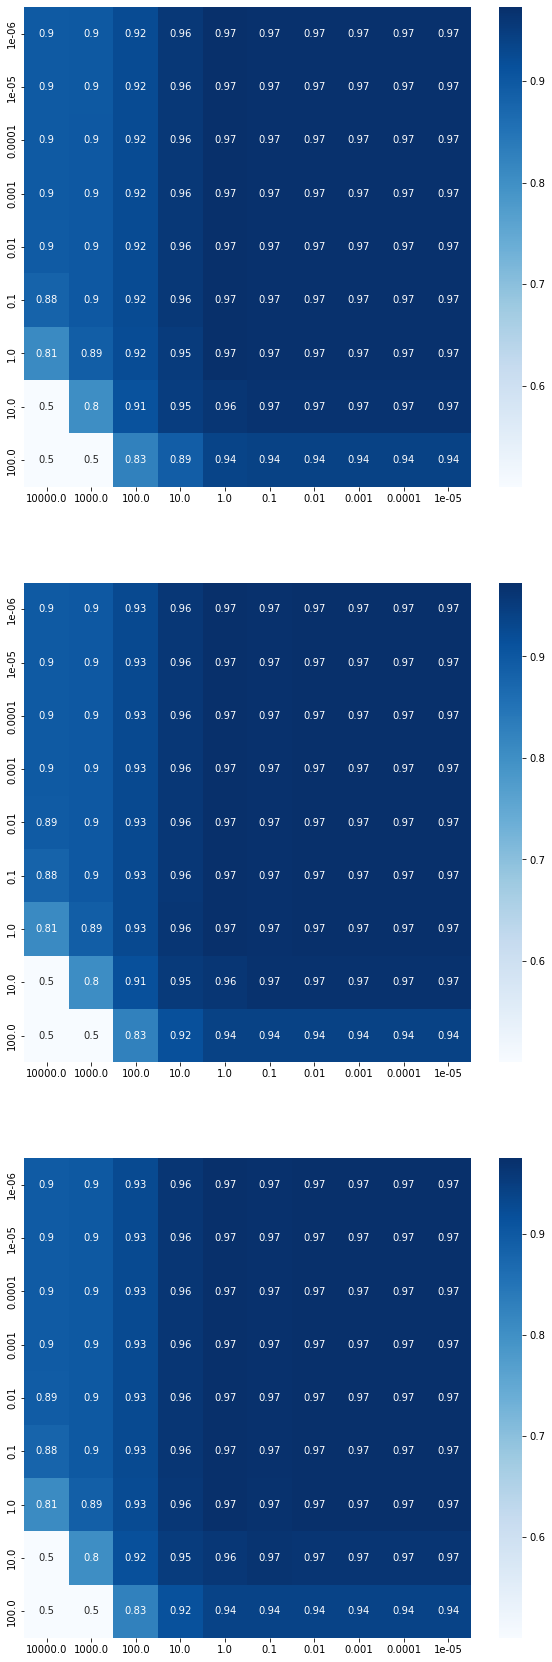

In [4]:
import seaborn as sns

fig, ax = plt.subplots(nrows = 3, figsize = (10,30))


for n_est in range(3,6):
    parameters = {'gamma': [10**i for i in range(-6,3)],
                  'reg_lambda': [10**(-i) for i in range(-4,6)] }

    clf = XGBClassifier(seed=1,
                        objective='binary:logistic',
                        learning_rate=0.4,
                        n_estimators= n_est)

    grid_search = GridSearchCV( estimator=clf,
                                param_grid = parameters,
                                cv = 4,
                                verbose = True)
    grid_search.fit(X,y)

    df = pd.DataFrame( grid_search.cv_results_['mean_test_score'].reshape(len(parameters['gamma']),
                                                                          len(parameters['reg_lambda'])),
                      index=parameters['gamma'], columns=parameters['reg_lambda'])

    sns.heatmap(df, annot=True, cmap='Blues', ax=ax[n_est-3])